<a href="https://colab.research.google.com/github/Gianuzzi/Proc_de_Img_-DD2020/blob/main/Ejercicio2.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libs (no tocar)
import os
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    from subprocess import getoutput
    getoutput("git clone -l -s https://gist.github.com/Gianuzzi/8500100a094ade398c55b827e55c6a3a cloned-repo")
    os.chdir('cloned-repo')
    import libs_PI
    os.chdir('/content')
    
from libs_PI import *

## Carga de imagen

Se debe otorgar el ``path`` al archivo. Puede ser un path del ordenador, o la URL de la imagen.

Por Default se intenta leer una imagen JPG; en caso de que sea otro formato, especificarlo. 

Formatos disponibles: **['png',  'jpeg', 'webp', 'bmp', 'dib', 'jpe', 'jp2',  'pbm', 'pgm', 'ppm', 'pxm', 'jpg', 'pnm']**

Tamaño de la imagen: (211, 350, 3)


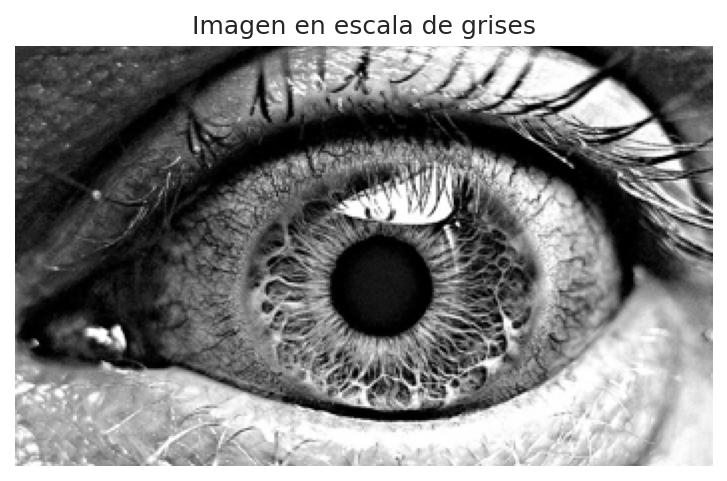

In [2]:
# Definir path y formato
path    = 'https://memyselfandela.files.wordpress.com/2012/04/black-and-white-tips.jpg'
formato = 'jpg'


# Cargamos el archivo
if in_colab:
    try:
        getoutput("wget "+path+" -O Imagen")
        path = os.path.join(os.getcwd(), 'Imagen')
    except:
        print('No se pudo descargar la imagen.')


img = mpimg.imread(path, format=formato)

# Definimos RGB normalizado
if img.ravel().dtype != float: img = img/255.

print('Tamaño de la imagen:', img.shape)    

# Luminancias?
lum  = True if len(img.shape)==2 else False
cmap = plt.cm.gray if lum else None
if lum: print('Parece que la imagen no presenta colores.\n'+\
              'Se considera que es una imagen de luminancias.')
    
# Ploteo
plt.figure(dpi=150)
plt.title('Imagen en escala de grises')
plt.axis('off')
plt.imshow(img, plt.cm.gray)
plt.show()

## Obtención de Y

Para este práctico, se trabajará con las luminancias.

In [3]:
if not lum:                                     # Si tiene colores...
    YIQ = RGBtoYIQ(img, normed=True, verb=True) # Pasamos a YIQ
    Y   = YIQ[:,:,0]                            # Obtenemos Y
else: Y = img

Se ha transformado de RGB a YIQ


# Aplicación de Filtro

## Definimos filtro

Parámetros:

    name  : Nombre del filtro. 
            Los posibles son:
             - 'identidad', 'identity'
             - 'plano', 'plain' 
             - 'gauss', 'gaussiano', 'gaussian' 
             - 'bartlett'
             - 'laplace', 'laplaciano', 'laplacian'
             - 'laplace_bordes', 'laplaciano_bordes', 'laplacian_edges'
             - 'sobel_norte', 'sobel_north'
             - 'sobel_sur', 'sobel_south' 
             - 'sobel_este', 'sobel_east' 
             - 'sobel_oeste', 'sobel_west'
             - 'sobel_noroeste', 'sobel_northwest', 'sobel_no', 'sobel_nw'
             - 'sobel_noreste', 'sobel_northeast', 'sobel_ne'
             - 'sobel_suroeste', 'sobel_southwest', 'sobel_so', 'sobel_sw'
             - 'sobel_sureste', 'sobel_southeast', 'sobel_se'
             - 'linea_horizontal', 'linea_h'
             - 'linea_vertical', 'linea_v'
             - 'linea_45'
             - 'linea_135' 
             - 'combinado', 'combined' [Requiere kwargs]
             - 'propio', 'custom'      [Requiere kwargs]
            (str)
    n     : Ancho de matriz de filtro. (int)
    norm  : Normalizar el filtro, si la suma de sus valores es > 1. (bool)
    
    kwargs: En caso de seleccionar operación: 'combinado' o 'combined', 
             se ejecuta la función FilterCombine:
                 filtro = filter_1 * c_1 'op' filter_2 * c_2
            Se debe introducir entonces:
                filtro_1: Nombre del filtro 1.
                filtro_2: Nombre del filtro 2.
                n_1     : Ancho de matriz de filtro 1.
                n_2     : Ancho de matriz de filtro 2.
                c_1     : Factor multiplicativo de matriz 1.
                c_2     : Factor multiplicativo de matriz 2.
                op      : Operación a realizar:
                            - 'suma',           'sum',      '+',
                            - 'resta',          'subtract', '-'
                            - 'multiplicacion', 'product',  '*'
                            - 'division',       'divide',   '/'
                            
            En caso de seleccionar operación: 'propio' o 'custom',
             se debe introducir como argumento:
                 matrix: Array con el filtro hecho manualmente.

In [4]:
# Filtro común
name  = 'gauss'
n     = 5

## Si name=='combinado' (Modificar a gusto)
kwargs = dict(
            filter_1 = 'gauss',
            filter_2 = 'laplace_bordes',
            n_1      = 5,
            n_2      = 3,
            c_1      = 0.8,
            c_2      = 1.1,
            op       = '*')

## Si name=='propio' (Modificar a gusto)
kwargs = dict(
            matrix = np.array([
                [1,2,3],
                [4,5,6],
                [7,8,9]]))


# No tocar
filtro = Filter(name=name, n=n, norm=True, **kwargs)
print('Filtro:\n', filtro)

Se generó un filtro "gauss" 5x5
Filtro:
 [[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]]


## Bordes

Se debe definir como se tratarán los bordes.
Hay 2 opciones disponibles hasta el momento:

    - Aplicar el filtro en la imagen original, resultando en la
       disminución del tamaño en [(ancho_filtro - 1) / 2] píxeles 
       en cada uno de los 4 bordes.
    - Aumentar el tamaño de la imagen original, agregando en cada
       uno de los 4 bordes [(ancho_filtro - 1) / 2] píxeles; para
       así, al aplciar el filtro, se reduzca al tamaño original.
       
Opciones:

    - 'original'
    - 'modificada'

In [5]:
# Seleccionar 'original' o 'modificada'
edges = 'modificada'


# No tocar
if   edges=='original'  :
    print('Se utiliza la imagen original.')
    Y_m = Y.copy()
elif edges=='modificada':
    Y_m = EnlargeImgY(Y, pad=(len(filtro) - 1) // 2)
    print('Se utiliza una imagen aumentada a:',Y_m.shape)
else: raise ValueError("Introduzca "+\
            "'original' o 'modificada'")

Se utiliza una imagen aumentada a: (215, 354)


## Chunks, Convolución y Cierre

1° Creamos _chuncks_ de la imagen, del tamaño del filtro.

2° Convolucionamos el filtro con la imagen, a través de cada chunk.

3° Aplicamos un cierre a la imagen, acotando las luminancias a [0,1).

In [6]:
#  No tocar
## Creamos chunks
chunks = Chunks(Y_m, filtro.shape) 
# Convolucionamos
Y_f    = np.einsum('ij,ijkl->kl', filtro, chunks.T).T  
# Cerramos
Y_f[Y_f>1] = 1
Y_f[Y_f<0] = 0

## Cierre

En caso de que alguna luminancia quede fuer del rango [0,1), se debe aplicar un cierre.

# Transformada de Fourier 2D y Ploteo

Calculamos la transformada de fourier de la imagen original y de la imagen modificada, para ver como varió al aplicar el filtro.

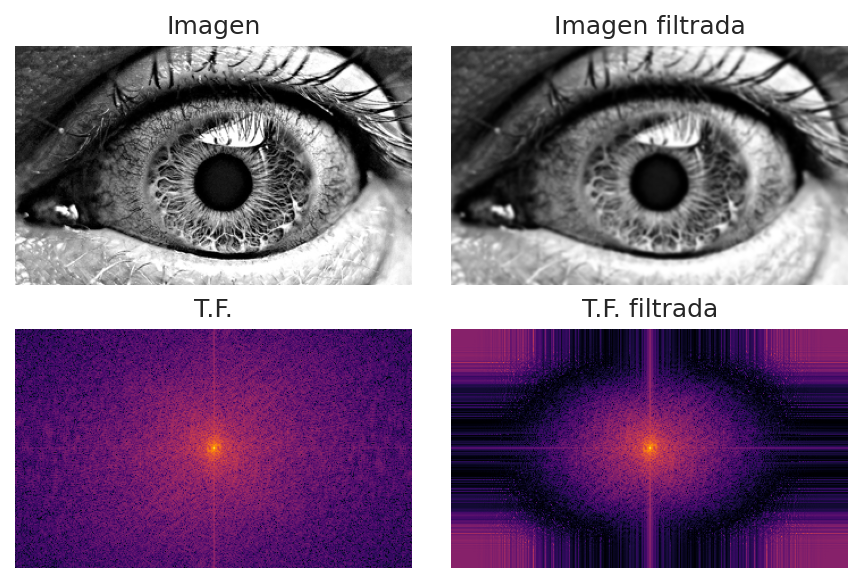

In [7]:
# Imagen Original
FT   = np.fft.fft2(Y)                # Descentrada
FT_c = np.fft.fftshift(FT)           # Centrada
FT_e = 20 * np.log(np.abs(FT_c))     # Escalado para plot

# Imagen modificada
FT_f   = np.fft.fft2(Y_f)            # Descentrada
FT_c_f = np.fft.fftshift(FT_f)       # Centrada
FT_e_f = 20 * np.log(np.abs(FT_c_f)) # Escalado para plot


# Ploteo
plt.figure(dpi=150)
plt.subplot(2,2,1)
plt.title('Imagen')
plt.axis('off')
plt.imshow(Y, plt.cm.gray)
plt.subplot(2,2,2)
plt.title('Imagen filtrada')
plt.axis('off')
plt.imshow(Y_f, plt.cm.gray)
plt.subplot(2,2,3)
plt.title('T.F.')
plt.axis('off')
plt.imshow(np.abs(FT_e), plt.cm.inferno)
plt.subplot(2,2,4)
plt.title('T.F. filtrada')
plt.axis('off')
plt.imshow(np.abs(FT_e_f), plt.cm.inferno)
plt.tight_layout()
plt.show()

# Guardado

Se debe especificar el nombre y formato.

In [8]:
nombre  = 'IMG_Ej2.1'
formato = 'jpg'

if not in_colab:
    RGB_f = (Y_f*255.).astype('uint8')
    IMG   = Image.fromarray(RGB_f)
    IMG.save(nombre+'.'+formato)